In [109]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import expon
from scipy.stats import weibull_min as weibull
from scipy.stats import burr12 as burr
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
from distrib_algs import *
from utils import *
from tests import *

%matplotlib inline

In [110]:
data_size = 2000

# Create the problem (for each value of num_of_workers run this code once)

In [55]:
%%time
dataset = "madelon"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Datasize: ", m, ", dimension: ", n)

In [56]:
#%%time
num_of_workers = 100
A, y, m, n, sparsity_A, data_split = prepare_data_distrib(dataset, data_size, num_of_workers)
print("New datasize: ", m, ", dimension: ", n)
L, average_L, worst_L = compute_L_distrib(dataset, A)
denseA = A.toarray()
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_ij : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)
print("Sparsity of A: ", sparsity_A)

In [57]:
save_split(dataset, num_of_workers, data_split)

# Find the solution (run these cells only once!)

In [62]:
%%time
A, y, m, n, sparsity_A = prepare_data(dataset)
A = A[0:data_size]
y = y[0:data_size]
m, n = A.shape
denseA = A.toarray()
L, average_L, worst_L = compute_L_distrib(dataset, A)
print("Datasize: ", m, ", dimension: ", n)
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_ij : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)

In [63]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L/10000
l1 = 0

In [64]:
#%%time
param = [A, y, l2, False, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-10)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

In [65]:
save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

# Tests with 20 workers

In [121]:
dataset = "madelon"
num_of_workers = 20
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Datasize: ", m, ", dimension: ", n)
L, average_L, worst_L = compute_L_distrib(dataset, A)
denseA = A.toarray()
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_ij : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)
print("Sparsity of A: ", sparsity_A)

Datasize:  2000 , dimension:  500
Smoothness constant of f         :  29790805.64933511
Average smoothness const of f_ij :  29904489.14662501
Worst smoothness const of f_ij   :  30596924.0
Sparsity of A:  0.999999


In [122]:
#%%time
A, y, m, n, sparsity_A = prepare_data(dataset)
A = A[0:data_size]
y = y[0:data_size]
m, n = A.shape
denseA = A.toarray()
L, average_L, worst_L = compute_L_distrib(dataset, A)
print("Datasize: ", m, ", dimension: ", n)
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_ij : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)

num_of_workers = 20
data_split = read_split(dataset, num_of_workers)

Datasize:  2000 , dimension:  500
Smoothness constant of f         :  29790805.64933511
Average smoothness const of f_ij :  29904489.14662501
Worst smoothness const of f_ij   :  30596924.0


In [123]:
shift_param = 0.0001
filename=dataset+"_x_star_shifted_by_all_ones_shift_"+str(shift_param)
l2 = L/10000
l1 = 0
batch_size = 1
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
x_init = x_star + shift_param*np.ones(n)

sparse_full = False
sparse_stoch = False

In [124]:
print("f(x^0) = ", logreg_loss(x_init, [denseA,y,l2,False,0]))
print("f(x^*) = ", f_star)

f(x^0) =  12.170929143981764
f(x^*) =  0.6679195537701466


In [90]:
1.0/(L+l2)

3.3564047302672275e-08

### Full grad methods

In [20]:
%%time
S = 50000
save_info_period = 100
gamma = 1.0/(L+l2)
sparsificator = identical
sparsificator_params = ["identical"]
res = ec_gd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=False, sparse_stoch=False, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 11min 8s, sys: 5.26 s, total: 11min 13s
Wall time: 1min 52s


In [13]:
%%time
S = 50000
save_info_period = 100
gamma = 1.0/(L+l2)
sparsificator = topk
sparsificator_params = ["top-1", 1]
res = ec_gd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=False, sparse_stoch=False, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 14min 59s, sys: 6.62 s, total: 15min 6s
Wall time: 2min 31s


In [24]:
%%time
S = 50000
save_info_period = 100
gamma = 1.0/(L+l2)
sparsificator = threshold
sparsificator_params = ["thr-1e-3", 1e-3]
res = ec_gd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=False, sparse_stoch=False, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 24min 28s, sys: 21.3 s, total: 24min 50s
Wall time: 4min 12s


In [21]:
%%time
S = 70000
save_info_period = 100
gamma = 1.0/(L+l2)
sparsificator = topk
sparsificator_params = ["top-1", 1]
res = ec_gd_star_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=False, sparse_stoch=False, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 24min 26s, sys: 15.2 s, total: 24min 41s
Wall time: 4min 9s


Initial func_vals is: 11.503009590211619
Initial func_vals is: 11.503009590211619


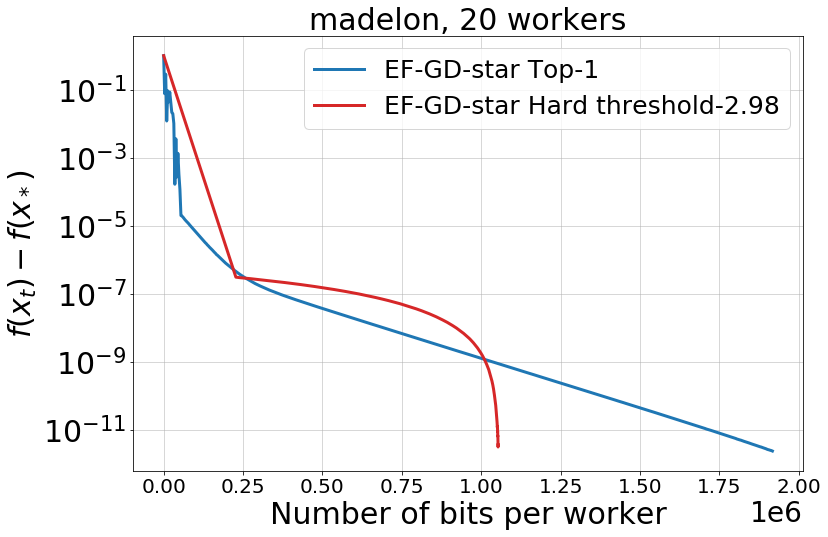

In [97]:
methods = [
#      ['EC_GD_const_stepsize', [1.0/(L+l2), l2, 50000, num_of_workers, "identical"], 
#            'GD', 500],
    ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 70000, num_of_workers, "top-1"], 
           'EF-GD-star Top-1', 600],
    ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 100000, num_of_workers, "thr-1e-7"], 
           'EF-GD-star Hard threshold-2.98', 600],
    
]
mode_y = 'func_vals'
mode_x = 'bits'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+r" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "gd_star_"+ dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [98]:
"gd_star_"+ dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"

'gd_star_madelon_num_of_workers_20_func_vals_bits.pdf'

Initial func_vals is: 11.503009590211619
Initial func_vals is: 11.503009590211619


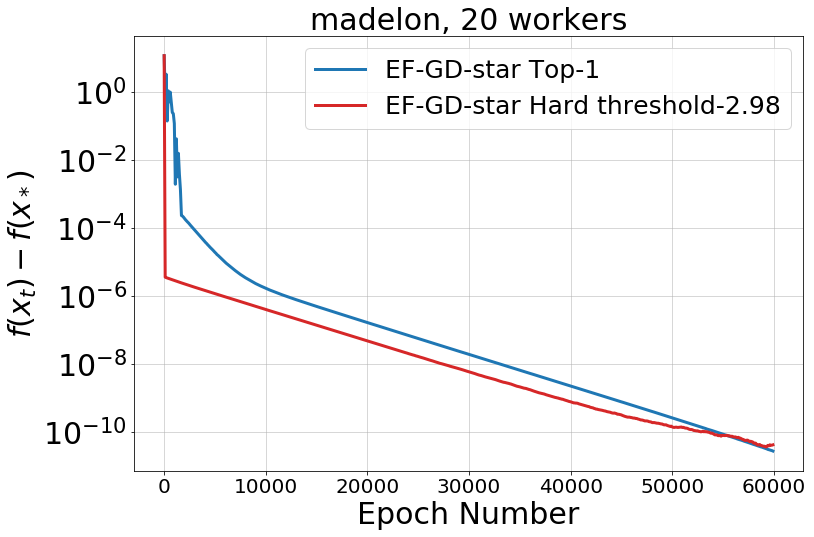

In [99]:
methods = [
#      ['EC_GD_const_stepsize', [1.0/(L+l2), l2, 50000, num_of_workers, "identical"], 
#            'GD', 500],
    ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 70000, num_of_workers, "top-1"], 
           'EF-GD-star Top-1', 600],
    ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 100000, num_of_workers, "thr-1e-7"], 
           'EF-GD-star Hard threshold-2.98', 600],
]
mode_y = 'func_vals'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+r" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "gd_star_"+ dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [100]:
"gd_star_"+ dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"

'gd_star_madelon_num_of_workers_20_func_vals_data_passes.pdf'

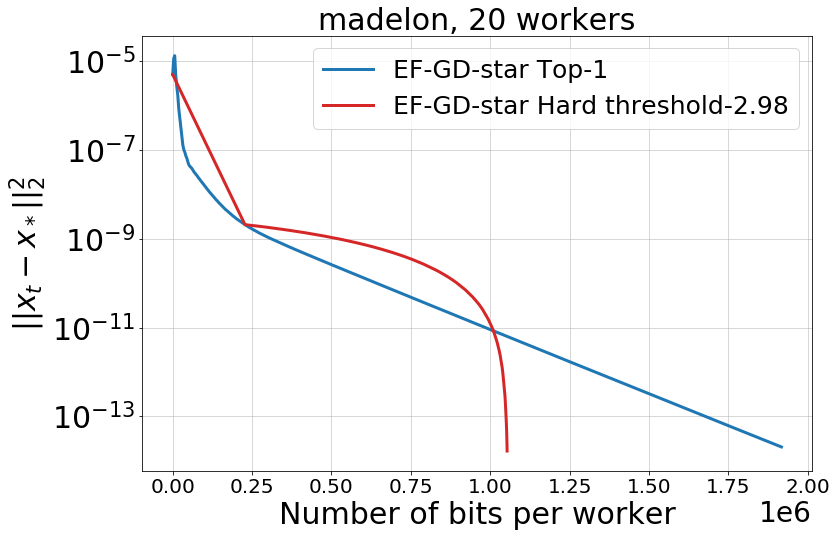

In [78]:
methods = [
#      ['EC_GD_const_stepsize', [1.0/(L+l2), l2, 50000, num_of_workers, "identical"], 
#            'GD', 500],
    ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 70000, num_of_workers, "top-1"], 
           'EF-GD-star Top-1', 600],
    ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 100000, num_of_workers, "thr-1e-7"], 
           'EF-GD-star Hard threshold-2.98', 600],
]
mode_y = 'squared_distances'
mode_x = 'bits'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+r" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "gd_star_"+ dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

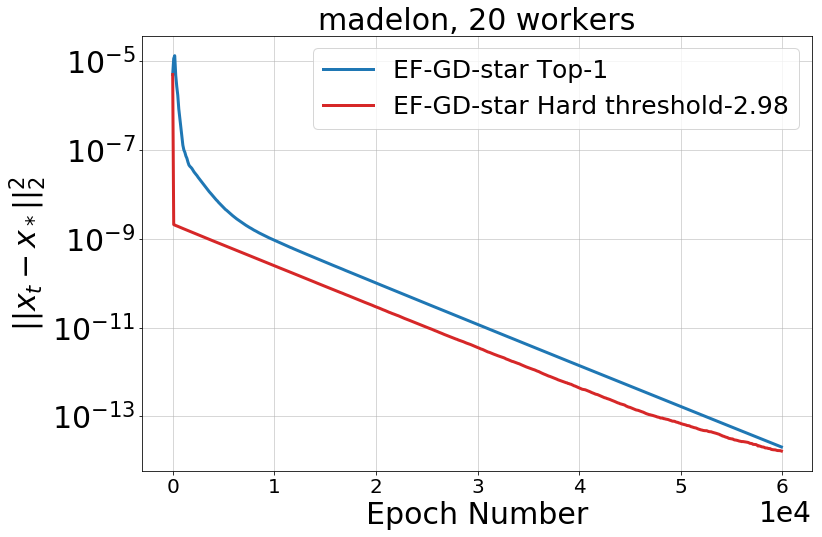

In [79]:
methods = [
#      ['EC_GD_const_stepsize', [1.0/(L+l2), l2, 50000, num_of_workers, "identical"], 
#            'GD', 500],
    ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 70000, num_of_workers, "top-1"], 
           'EF-GD-star Top-1', 600],
    ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 100000, num_of_workers, "thr-1e-7"], 
           'EF-GD-star Hard threshold-2.98', 600],
    
]
mode_y = 'squared_distances'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+r" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "gd_star_"+ dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

# Error norm vs iterations

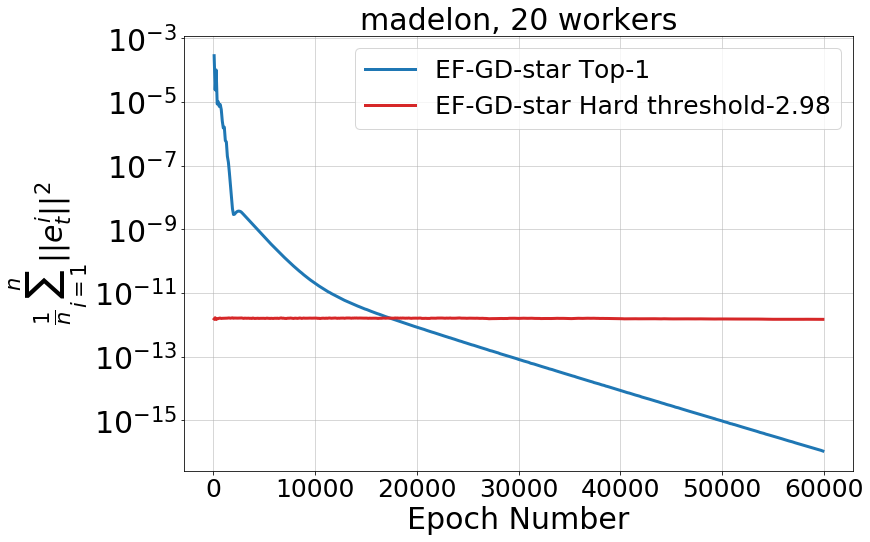

In [125]:
methods = [
#      ['EC_GD_const_stepsize', [1.0/(L+l2), l2, 50000, num_of_workers, "identical"], 
#            'GD', 500],
    ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 70000, num_of_workers, "top-1"], 
           'EF-GD-star Top-1', 600],
    ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 100000, num_of_workers, "thr-1e-7"], 
           'EF-GD-star Hard threshold-2.98', 600],

]
mode_y = 'avg_error_norms'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 25
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "gd_star_"+ dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [102]:
"gd_star_"+ dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"

'gd_star_madelon_num_of_workers_20_avg_error_norms_data_passes.pdf'

# Tests with 100 workers

In [116]:
#%%time
dataset = "madelon"
A, y, m, n, sparsity_A = prepare_data(dataset)
A = A[0:data_size]
y = y[0:data_size]
m, n = A.shape
denseA = A.toarray()
L, average_L, worst_L = compute_L_distrib(dataset, A)
print("Datasize: ", m, ", dimension: ", n)
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_ij : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)

num_of_workers = 100
data_split = read_split(dataset, num_of_workers)

Datasize:  2000 , dimension:  500
Smoothness constant of f         :  29790805.64933511
Average smoothness const of f_ij :  29904489.14662501
Worst smoothness const of f_ij   :  30596924.0


In [117]:
shift_param = 0.0001
filename=dataset+"_x_star_shifted_by_all_ones_shift_"+str(shift_param)
l2 = L/10000
l1 = 0
batch_size = 1
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
x_init = x_star + shift_param*np.ones(n)

sparse_full = False
sparse_stoch = False

In [118]:
print("f(x^0) = ", logreg_loss(x_init, [denseA,y,l2,False,0]))
print("f(x^*) = ", f_star)

f(x^0) =  12.170929143981764
f(x^*) =  0.6679195537701466


### Full grad methods

In [75]:
%%time
S = 50000
save_info_period = 100
gamma = 1.0/(L+l2)
sparsificator = identical
sparsificator_params = ["identical"]
res = ec_gd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=False, sparse_stoch=False, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 4min 33s, sys: 2.58 s, total: 4min 36s
Wall time: 4min 36s


In [78]:
%%time
S = 50000
save_info_period = 100
gamma = 1.0/(L+l2)
sparsificator = topk
sparsificator_params = ["top-5", 5]
res = ec_gd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=False, sparse_stoch=False, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 7min 28s, sys: 3.52 s, total: 7min 32s
Wall time: 7min 32s


In [81]:
%%time
S = 50000
save_info_period = 100
gamma = 1.0/(L+l2)
sparsificator = threshold
sparsificator_params = ["thr-1e-7", 1e-7]
res = ec_gd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=False, sparse_stoch=False, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 5min 44s, sys: 2.81 s, total: 5min 47s
Wall time: 5min 47s


In [83]:
%%time
S = 100000
save_info_period = 100
gamma = 1.0/(L+l2)
sparsificator = topk
sparsificator_params = ["top-5", 5]
res = ec_gd_star_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=False, sparse_stoch=False, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 15min 51s, sys: 6.3 s, total: 15min 57s
Wall time: 16min 4s


In [84]:
%%time
S = 100000
save_info_period = 100
gamma = 1.0/(L+l2)
sparsificator = threshold
sparsificator_params = ["thr-1e-7", 1e-7]
res = ec_gd_star_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=False, sparse_stoch=False, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 12min 37s, sys: 4.49 s, total: 12min 42s
Wall time: 12min 42s


Initial func_vals is: 11.503009590211619
Initial func_vals is: 11.503009590211619


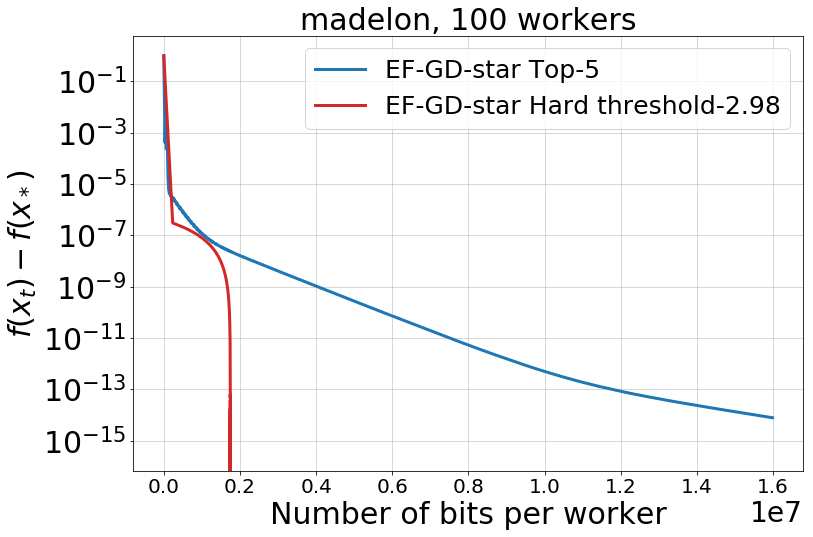

In [106]:
methods = [
#      ['EC_GD_const_stepsize', [1.0/(L+l2), l2, 50000, num_of_workers, "identical"], 
#            'GD', 500],
     ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 100000, num_of_workers, "top-5"], 
           'EF-GD-star Top-5', 1000],
    ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 100000, num_of_workers, "thr-1e-7"], 
           'EF-GD-star Hard threshold-2.98', 1000],
]
mode_y = 'func_vals'
mode_x = 'bits'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+r" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "gd_star_"+ dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

Initial func_vals is: 11.503009590211619
Initial func_vals is: 11.503009590211619


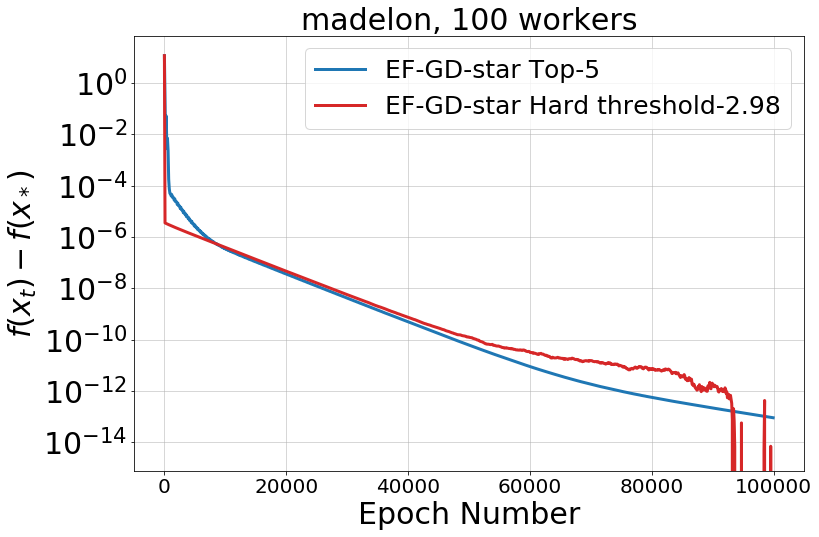

In [107]:
methods = [
#      ['EC_GD_const_stepsize', [1.0/(L+l2), l2, 50000, num_of_workers, "identical"], 
#            'GD', 500],
     ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 100000, num_of_workers, "top-5"], 
           'EF-GD-star Top-5', 1000],
    ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 100000, num_of_workers, "thr-1e-7"], 
           'EF-GD-star Hard threshold-2.98', 1000],
]
mode_y = 'func_vals'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+r" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "gd_star_"+ dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [ ]:
dataset

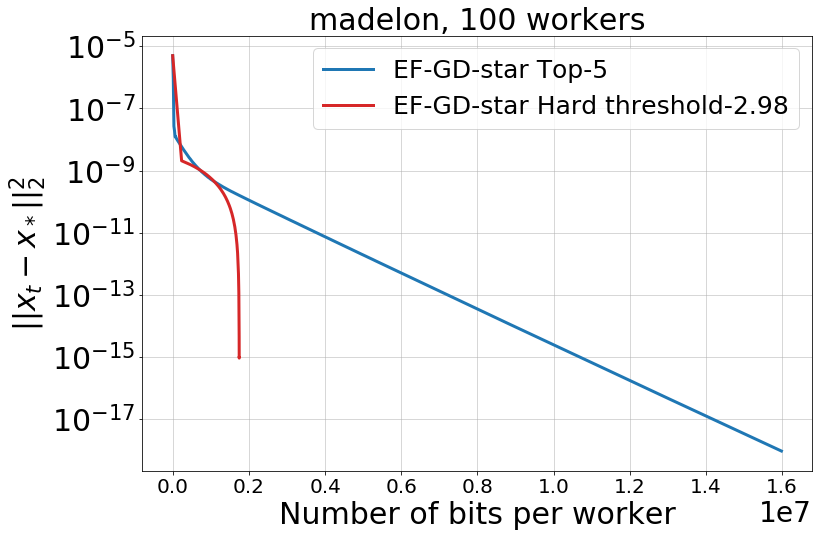

In [59]:
methods = [
#      ['EC_GD_const_stepsize', [1.0/(L+l2), l2, 50000, num_of_workers, "identical"], 
#            'GD', 500],
     ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 100000, num_of_workers, "top-5"], 
           'EF-GD-star Top-5', 1000],
    ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 100000, num_of_workers, "thr-1e-7"], 
           'EF-GD-star Hard threshold-2.98', 1000],
]
mode_y = 'squared_distances'
mode_x = 'bits'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+r" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "gd_star_"+ dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

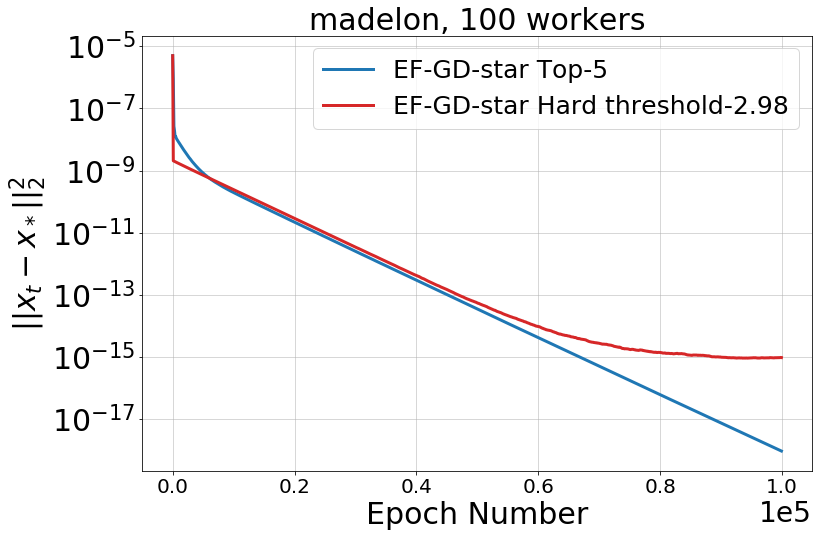

In [60]:
methods = [
#      ['EC_GD_const_stepsize', [1.0/(L+l2), l2, 50000, num_of_workers, "identical"], 
#            'GD', 500],
     ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 100000, num_of_workers, "top-5"], 
           'EF-GD-star Top-5', 1000],
    ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 100000, num_of_workers, "thr-1e-7"], 
           'EF-GD-star Hard threshold-2.98', 1000],
]
mode_y = 'squared_distances'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+r" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "gd_star_"+ dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

# Error norm vs iterations

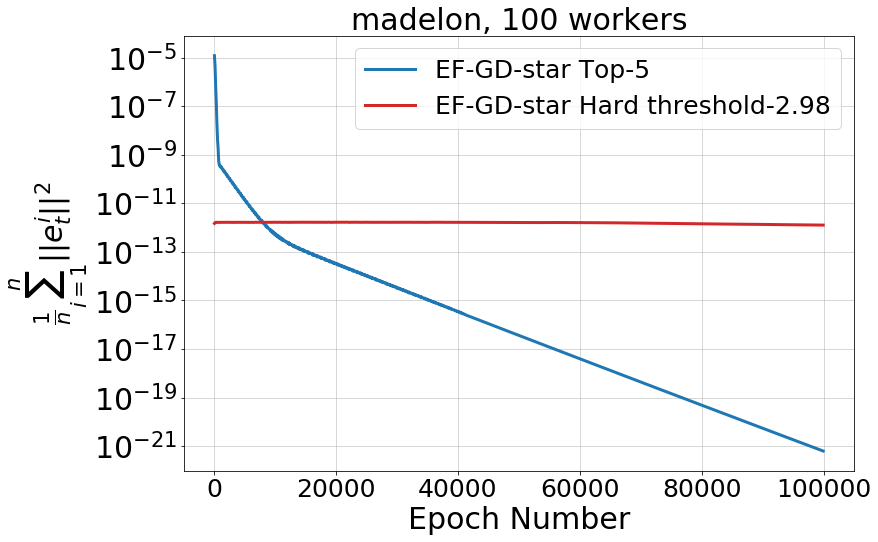

In [120]:
methods = [
#      ['EC_GD_const_stepsize', [1.0/(L+l2), l2, 50000, num_of_workers, "identical"], 
#            'GD', 500],
     ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 100000, num_of_workers, "top-5"], 
           'EF-GD-star Top-5', 1000],
    ['EC_GD_star_const_stepsize', [1.0/(L+l2), l2, 100000, num_of_workers, "thr-1e-7"], 
           'EF-GD-star Hard threshold-2.98', 1000],
]
mode_y = 'avg_error_norms'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 25
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "gd_star_"+ dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)